/var/folders/bv/ghjrxv6j7pl2ttzvdds70ldh0000gn/T/ipykernel_85749/2283322013.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned[column].fillna(median_value, inplace=True)
/var/folders/bv/ghjrxv6j7pl2ttzvdds70ldh0000gn/T/ipykernel_85749/2283322013.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

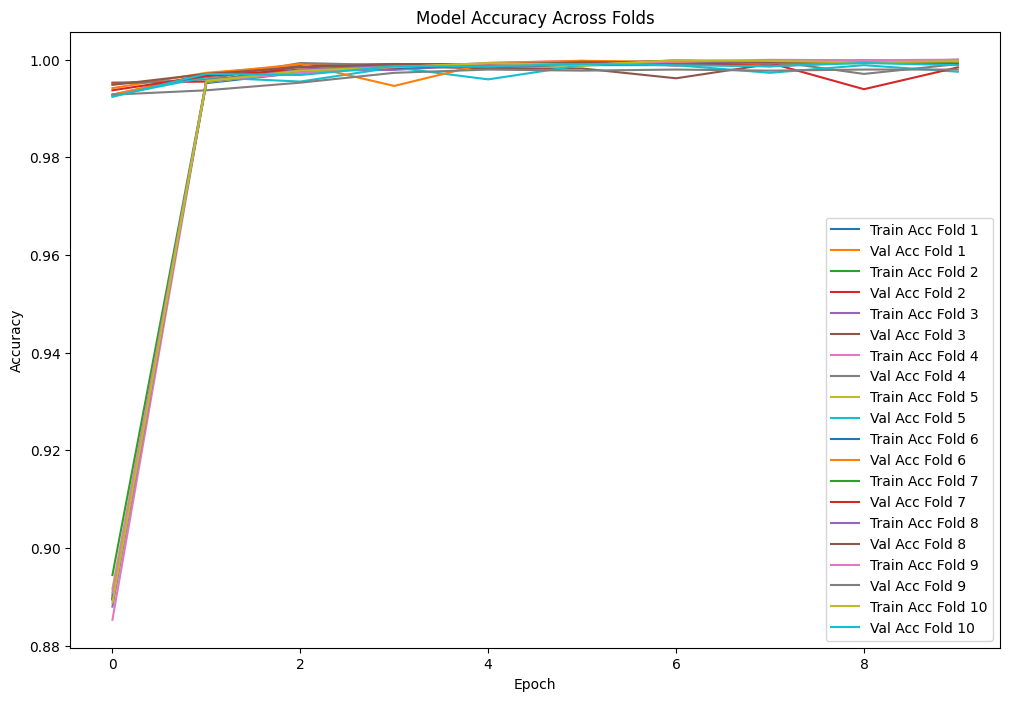

In [7]:
# Import necessary libraries
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Install necessary packages using pip
!{sys.executable} -m pip install pandas tensorflow scikit-learn matplotlib
!{sys.executable} -m pip install --upgrade pip

# Load the dataset
file_path = 'Vehicle MPG - 1984 to 2023.csv'
data = pd.read_csv(file_path)

# Drop the 'Model' column
data_dropped = data.drop('Model', axis=1)

# Drop additional specified columns
data_cleaned = data_dropped.drop(['Fuel Type 2', 'Engine Description'], axis=1)

# Fill missing numeric values with the median
for column in ['Engine Cylinders', 'Engine Displacement']:
    median_value = data_cleaned[column].median()
    data_cleaned[column].fillna(median_value, inplace=True)

# Drop rows with any remaining missing values
data_cleaned.dropna(inplace=True)

# Select categorical and numeric columns
categorical_columns = ['Make', 'Fuel Type 1', 'Drive', 'Transmission', 'Vehicle Class']
numeric_columns = [col for col in data_cleaned.columns if col not in categorical_columns and data_cleaned[col].dtype in ['int64', 'float64']]

# One-hot encode categorical columns
one_hot_encoder = OneHotEncoder()
encoded_categorical = one_hot_encoder.fit_transform(data_cleaned[categorical_columns]).toarray()
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=one_hot_encoder.get_feature_names_out(categorical_columns))
encoded_categorical_df.index = data_cleaned.index

# Normalize numeric columns
scaler = StandardScaler()
normalized_numeric = scaler.fit_transform(data_cleaned[numeric_columns])
normalized_numeric_df = pd.DataFrame(normalized_numeric, columns=numeric_columns)
normalized_numeric_df.index = data_cleaned.index

# Combine encoded and normalized data
final_preprocessed_data = pd.concat([encoded_categorical_df, normalized_numeric_df], axis=1)

# Prepare target and features
X = final_preprocessed_data
if 'Make' in data_cleaned.columns:
    y = pd.get_dummies(data_cleaned['Make'])  # Assuming 'Make' is the target column

# Define k-fold cross-validation
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Convert y to encoded labels for stratification
if y.ndim == 1 or y.shape[1] == 1:
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y.ravel())
else:
    y_encoded = np.argmax(y, axis=1)

# Function to create model
def create_model(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize lists to store histories
all_histories = []

# Iterate over each split
for train_index, test_index in skf.split(X, y_encoded):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = create_model(X_train.shape[1], y_train.shape[1])
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(X_test, y_test))
    all_histories.append(history)

# Plot accuracy for each fold
plt.figure(figsize=(12, 8))
for i, history in enumerate(all_histories):
    plt.plot(history.history['accuracy'], label=f'Train Acc Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Acc Fold {i+1}')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()